# Simulação de Reservatórios de Petróleo – 2021/2

## Trabalho 2

**Grupo:** Luan Rodrigues e Matheus Harduim.

**Professor:** Grazione de Souza.

**Instituição:** UERJ – IPRJ – DMC

### Desenvolvimento dos códigos e comentários.

Importando as bibliotecas do python que serão utilizadas

In [1]:
import numpy.matlib
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize

## Dados do problema
- $k = 10,0 × {10}^{−15} {m}^{2}$
- $φ = 0,25$
- ${S}_{w inicial} = 0,2$
- ${L}_{x} = 5000m$
- ${L}_{y} = 40m$
- ${L}_{z} = 10m$
- ${µ}_{w} = 1,0 × {10}^{−3}Pa·s$
- ${µ}_{o} = 0,8 × {10}^{−3}Pa·s$

In [2]:
k = 10.0* (10**-15)
phi = 0.25
Sw_inicial = 0.2
C = 0.8
L_x = 5000
L_y = 40
L_z = 10
miw = 1.0*(10**-3)
mio = 0.8*(10**-3)
qt = 20

In [3]:
2*mio*miw

1.6000000000000001e-06

In [4]:
def calcfw(Sw, mi_w, mi_o, cte):
    
    return cte*(1/(1 + ((1-Sw)**2/Sw**2)*(mi_w/mi_o)))

def calcDerivatefw(Sw, mi_w, mi_o, cte):
    return -cte*(2*mi_o*mi_w*(Sw-1)*Sw)/((mi_o*Sw**2 + mi_w*(Sw - 1)**2)**2)
# possivel função pra calcular delta_t 
#def calc

In [5]:
def calcSw(Sw_in, C, mi_w, mi_o, qt, phi, L_x, L_y, L_z, n_x, tempo_total):
    vetor_Sw = np.ones(n_x)*Sw_in
    delta_x = L_x / n_x
    vetor_Sw[0] = C
    # Area de seção transversal do reservatorio
    A = Ly*Lz
    #Calculando a parte constante de F_w
    cte = qt/(A*phi)
    t = 0
    #calculando o valor maximo da derivada de Fw
    u_max = float(optimize.fmin(lambda x: -calcDerivatefw(x, mi_w, mi_o, cte), 0, disp=False)[0])
    u_max = calcDerivatefw(u_max, mi_w, mi_o, cte)
    delta_t = delta_x / u_max
    #print(f'delta_t : {delta_t}')
    delta_t = 1
    while t < tempo_total:
        #calculando o valor maximo da derivada de Fw
        vetor_Swn = np.array([])
        for i in range(len(vetor_Sw)):
            if i == 0:
                # Q^n_i - 1
                Fw_1 = calcfw(2*C + vetor_Sw[0],mi_w, mi_o, cte) # calculando o nó fantasma
                # Q^n_i
                Fw = calcfw(C,mi_w, mi_o, cte)
            elif i == 1:
                # Q^n_i - 1
                Fw_1 = calcfw(C,mi_w, mi_o, cte)
                # Q^n_i
                Fw = calcfw(vetor_Sw[i],mi_w, mi_o, cte)
            else:
                # Q^n_i - 1
                Fw_1 = calcfw(vetor_Sw[i-1],mi_w, mi_o, cte)
                # Q^n_i - 1
                Fw = calcfw(vetor_Sw[i],mi_w, mi_o, cte)
            #Calculo de Sw_(i)^(n+1)
            p1 = (delta_t/delta_x)*(Fw-Fw_1)
            Sw_n = vetor_Sw[i] - p1
            if i == len(vetor_Sw)-1:
                Sw_n = vetor_Sw[i]
            vetor_Swn = np.append(vetor_Swn, Sw_n)
        vetor_Sw = vetor_Swn
        t = t + delta_t
    df = pd.DataFrame(columns=['Sw','So'])
    vetor_So = 1 - vetor_Sw
    df['Sw'] = vetor_Sw
    #df['So'] = vetor_So
    df.index = (df.index + 1)*delta_x
    return df

# Resultados para os dados da proposta

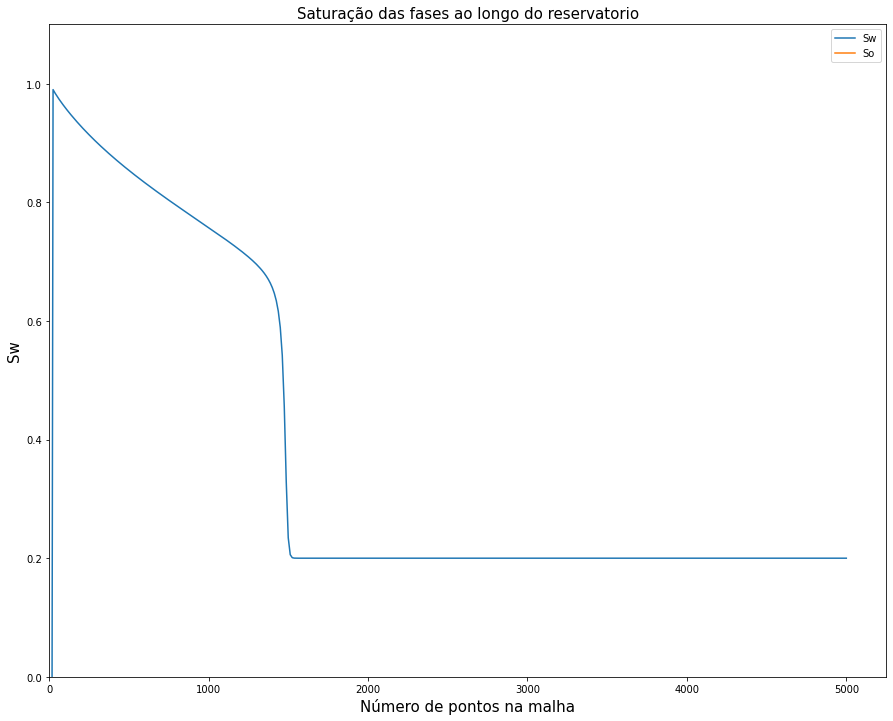

In [17]:
k = 10.0* (10**-15)
phi = 0.25
Sw_inicial = 0.2
C = 1
Lx = 5000
Ly = 40
Lz = 10
miw = 1.0*(10**-3)
mio = 0.8*(10**-3)
qt = 85
tempo_total = 365*3
n_x = 400

df = calcSw(Sw_inicial, C, miw, mio, qt, phi, Lx, Ly, Lz, n_x, tempo_total)
f, a = plt.subplots(1,1, figsize=(15,12))
df.plot(ax=a)
a.set_title(f'Saturação das fases ao longo do reservatorio', fontsize=15)
a.set_xlabel('Número de pontos na malha',fontsize=15)
a.set_ylabel('Sw',fontsize=15)
a.axis(xmin=0)
a.axis(ymin=0.0,ymax=1.1)
plt.show()

# Início dos testes

## Refinamento de malha

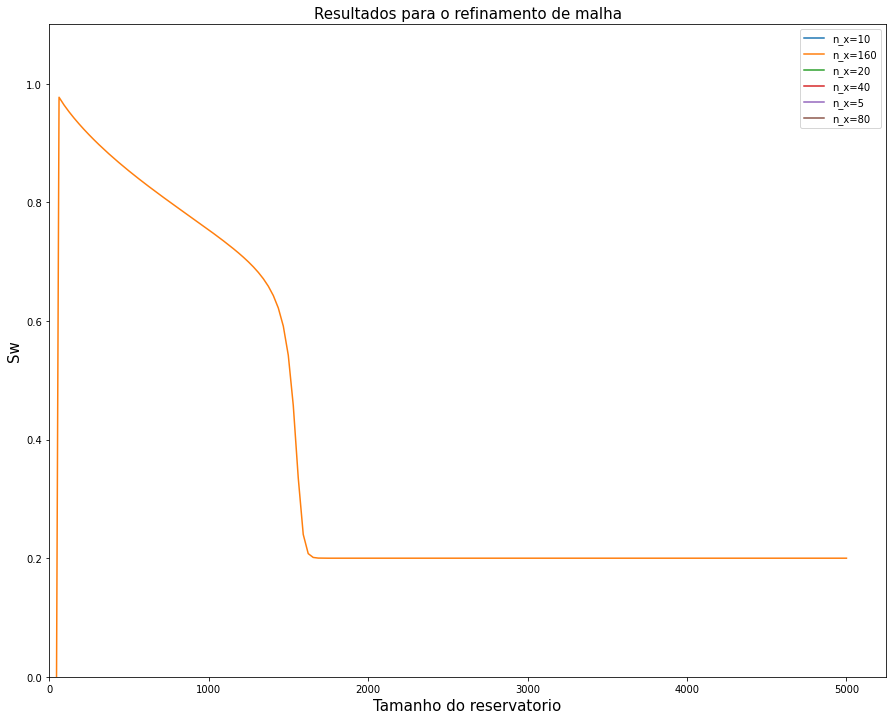

In [18]:
k = 10.0* (10**-15)
phi = 0.25
Sw_inicial = 0.2
C = 1
Lx = 5000
Ly = 40
Lz = 10
miw = 1.0*(10**-3)
mio = 0.8*(10**-3)
qt = 85
tempo_total = 365*3
n_x = 400
nxs = [5, 10, 20, 40, 80, 160]
my_list = []
for n_x in nxs:
    df = calcSw(Sw_inicial, C, miw, mio, qt, phi, Lx, Ly, Lz, n_x, tempo_total)
    df = df.rename(columns={'Sw':f'n_x={n_x}'})
    my_list.append(df)
df = pd.concat([df.stack() for df in my_list], axis=0).unstack()
f, a = plt.subplots(1,1, figsize=(15,12))
df.plot(ax=a)
a.set_title(f'Resultados para o refinamento de malha', fontsize=15)
a.set_xlabel('Tamanho do reservatorio',fontsize=15)
a.set_ylabel('Sw',fontsize=15)
a.axis(xmin=0)
a.axis(ymin=0.0,ymax=1.1)
plt.show()

## Teste de Variação de Tempo Total

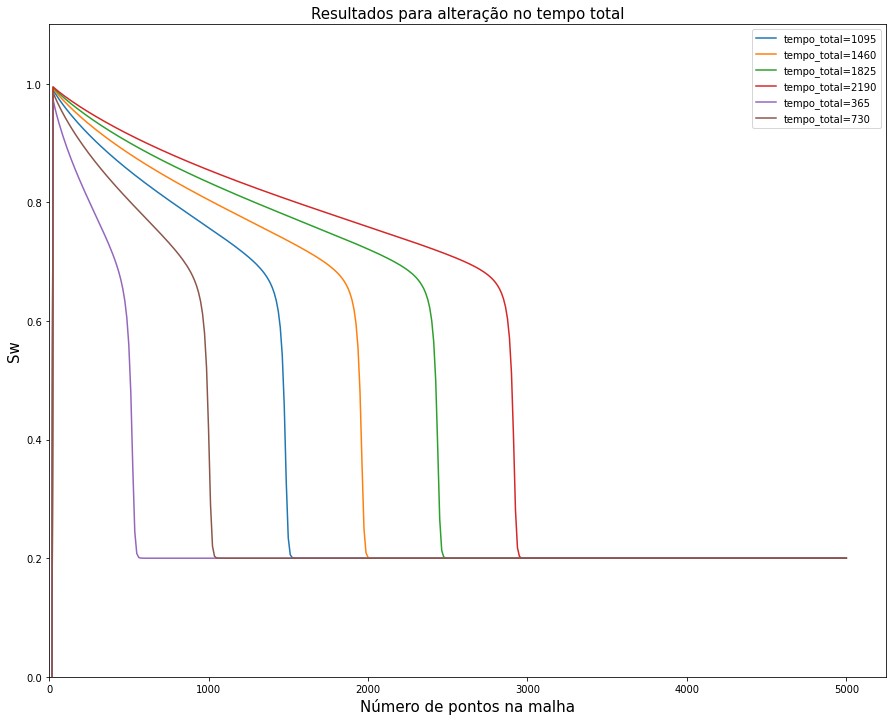

In [19]:
k = 10.0* (10**-15)
phi = 0.25
Sw_inicial = 0.2
C = 1
Lx = 5000
Ly = 40
Lz = 10
miw = 1.0*(10**-3)
mio = 0.8*(10**-3)
qt = 85
tempo_total = 365*3
n_x = 400
tempo_totals = np.arange(1,7)*365
my_list = []
for tempo_total in tempo_totals:
    df = calcSw(Sw_inicial, C, miw, mio, qt, phi, Lx, Ly, Lz, n_x, tempo_total)
    df = df.rename(columns={'Sw':f'tempo_total={tempo_total}'})
    my_list.append(df)
df = pd.concat([df.stack() for df in my_list], axis=0).unstack()
f, a = plt.subplots(1,1, figsize=(15,12))
df.plot(ax=a)
a.set_title(f'Resultados para alteração no tempo total', fontsize=15)
a.set_xlabel('Número de pontos na malha',fontsize=15)
a.set_ylabel('Sw',fontsize=15)
a.axis(xmin=0)
a.axis(ymin=0.0,ymax=1.1)
plt.show()

## Teste de Variação de Vazão de Água

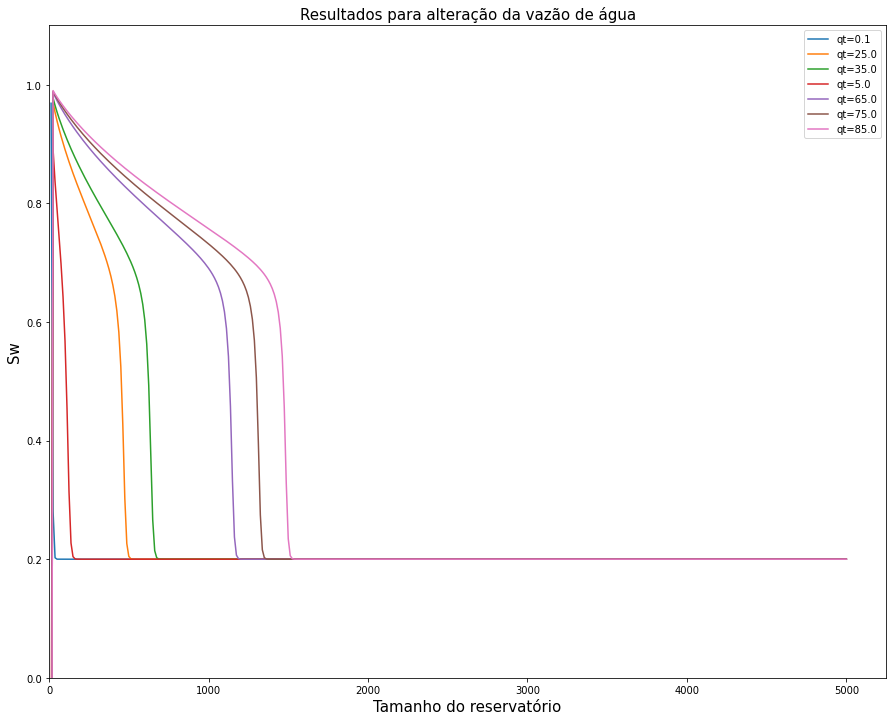

In [20]:
k = 10.0* (10**-15)
phi = 0.25
Sw_inicial = 0.2
C = 1
Lx = 5000
Ly = 40
Lz = 10
miw = 1.0*(10**-3)
mio = 0.8*(10**-3)
qts = [85.0,75.0,65.0,35.0,25.0,5.0,0.1]
tempo_total = 365*3
n_x = 400
my_list = []
for qt in qts:
    df = calcSw(Sw_inicial, C, miw, mio, qt, phi, Lx, Ly, Lz, n_x, tempo_total)
    df = df.rename(columns={'Sw':f'qt={qt}'})
    my_list.append(df)
df = pd.concat([df.stack() for df in my_list], axis=0).unstack()
f, a = plt.subplots(1,1, figsize=(15,12))
df.plot(ax=a)
a.set_title(f'Resultados para alteração da vazão de água', fontsize=15)
a.set_xlabel('Tamanho do reservatório',fontsize=15)
a.set_ylabel('Sw',fontsize=15)
a.axis(xmin=0)
a.axis(ymin=0.0,ymax=1.1)
plt.show()

## Teste de Variação de Saturação Inicial

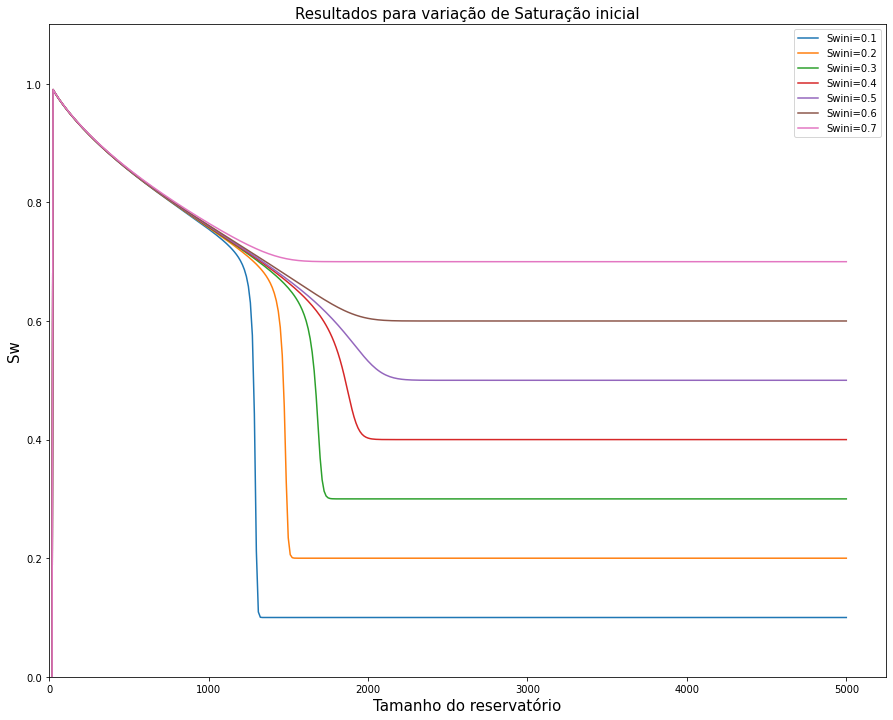

In [21]:
k = 10.0* (10**-15)
phi = 0.25
Sw_inicials = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
C = 1
Lx = 5000
Ly = 40
Lz = 10
miw = 1.0*(10**-3)
mio = 0.8*(10**-3)
qt = 85.0
tempo_total = 365*3
n_x = 400
my_list = []
for Sw_inicial in Sw_inicials:
    df = calcSw(Sw_inicial, C, miw, mio, qt, phi, Lx, Ly, Lz, n_x, tempo_total)
    df = df.rename(columns={'Sw':f'Swini={Sw_inicial}'})
    my_list.append(df)
df = pd.concat([df.stack() for df in my_list], axis=0).unstack()
f, a = plt.subplots(1,1, figsize=(15,12))
df.plot(ax=a)
a.set_title(f'Resultados para variação de Saturação inicial', fontsize=15)
a.set_xlabel('Tamanho do reservatório',fontsize=15)
a.set_ylabel('Sw',fontsize=15)
a.axis(xmin=0)
a.axis(ymin=0.0,ymax=1.1)
plt.show()

## Teste de Variação de Porosidade

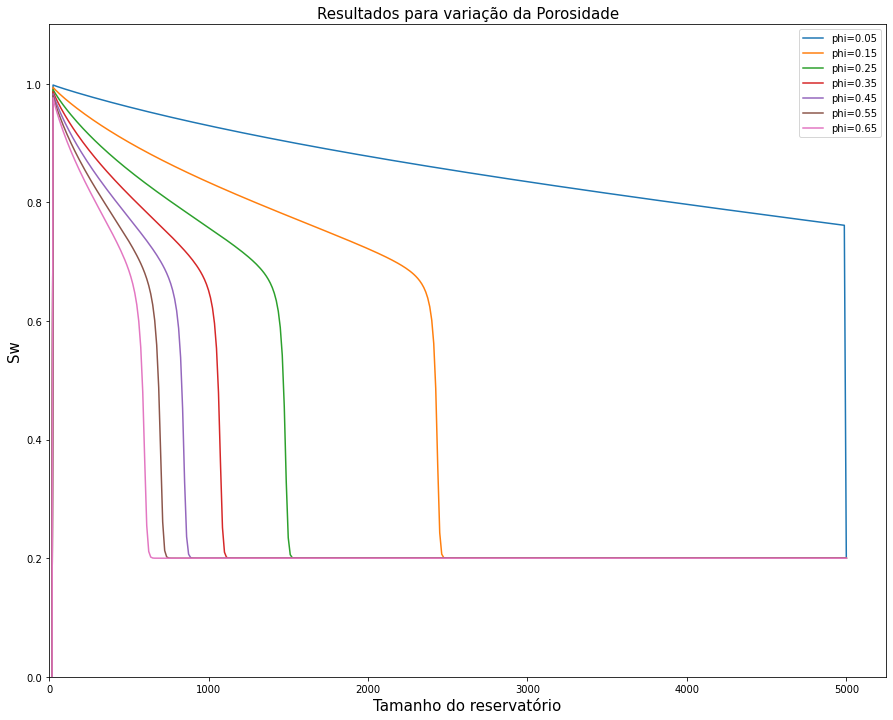

In [22]:
k = 10.0* (10**-15)
phis = [0.05,0.15,0.25,0.35,0.45,0.55,0.65]
Sw_inicial = 0.2
C = 1
Lx = 5000
Ly = 40
Lz = 10
miw = 1.0*(10**-3)
mio = 0.8*(10**-3)
qt = 85.0
tempo_total = 365*3
n_x = 400
my_list = []
for phi in phis:
    df = calcSw(Sw_inicial, C, miw, mio, qt, phi, Lx, Ly, Lz, n_x, tempo_total)
    df = df.rename(columns={'Sw':f'phi={phi}'})
    my_list.append(df)
df = pd.concat([df.stack() for df in my_list], axis=0).unstack()
f, a = plt.subplots(1,1, figsize=(15,12))
df.plot(ax=a)
a.set_title(f'Resultados para variação da Porosidade', fontsize=15)
a.set_xlabel('Tamanho do reservatório',fontsize=15)
a.set_ylabel('Sw',fontsize=15)
a.axis(xmin=0)
a.axis(ymin=0.0,ymax=1.1)
plt.show()

## Teste de variação de Viscosidade 

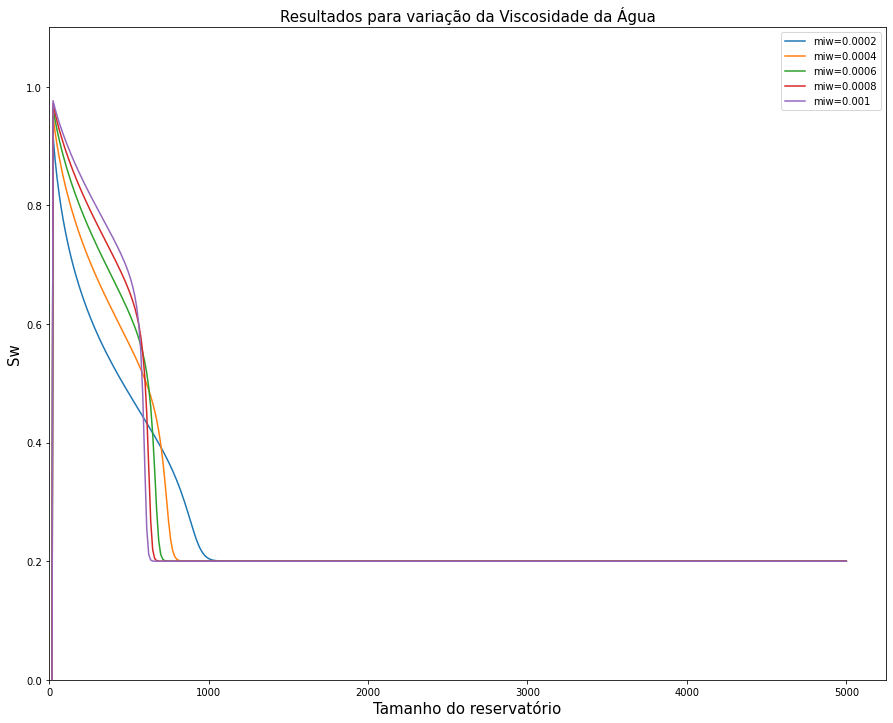

In [23]:
k = 10.0* (10**-15)
phis = 0.25
Sw_inicial = 0.2
C = 1
Lx = 5000
Ly = 40
Lz = 10
miws = 1.0*(10**-3)*np.array([0.2,0.4,0.6,0.8,1.0])
mio = 0.8*(10**-3)
qt = 85.0
tempo_total = 365*3
n_x = 400
my_list = []
for miw in miws:
    df = calcSw(Sw_inicial, C, miw, mio, qt, phi, Lx, Ly, Lz, n_x, tempo_total)
    df = df.rename(columns={'Sw':f'miw={miw}'})
    my_list.append(df)
df = pd.concat([df.stack() for df in my_list], axis=0).unstack()
f, a = plt.subplots(1,1, figsize=(15,12))
df.plot(ax=a)
a.set_title(f'Resultados para variação da Viscosidade da Água', fontsize=15)
a.set_xlabel('Tamanho do reservatório',fontsize=15)
a.set_ylabel('Sw',fontsize=15)
a.axis(xmin=0)
a.axis(ymin=0.0,ymax=1.1)
plt.show()

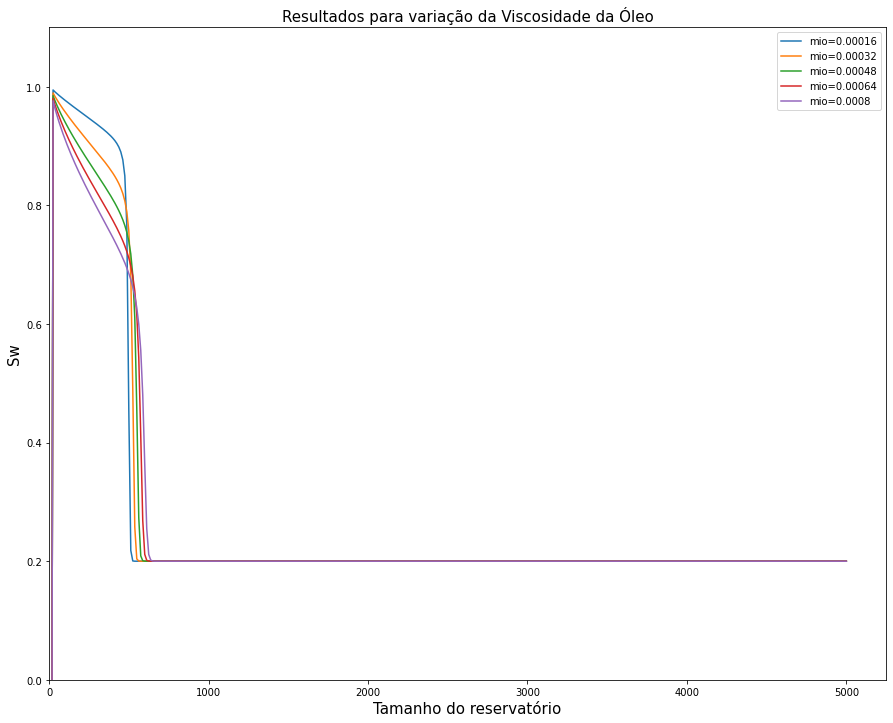

In [24]:
k = 10.0* (10**-15)
phis = 0.25
Sw_inicial = 0.2
C = 1
Lx = 5000
Ly = 40
Lz = 10
miw = 1.0*(10**-3)
mios = 0.8*(10**-3)*np.array([0.2,0.4,0.6,0.8,1.0])
qt = 85.0
tempo_total = 365*3
n_x = 400
my_list = []
for mio in mios:
    df = calcSw(Sw_inicial, C, miw, mio, qt, phi, Lx, Ly, Lz, n_x, tempo_total)
    df = df.rename(columns={'Sw':f'mio={mio}'})
    my_list.append(df)
df = pd.concat([df.stack() for df in my_list], axis=0).unstack()
f, a = plt.subplots(1,1, figsize=(15,12))
df.plot(ax=a)
a.set_title(f'Resultados para variação da Viscosidade da Óleo', fontsize=15)
a.set_xlabel('Tamanho do reservatório',fontsize=15)
a.set_ylabel('Sw',fontsize=15)
a.axis(xmin=0)
a.axis(ymin=0.0,ymax=1.1)
plt.show()